# Quotations Behind Brexit

Brexit (a portmanteau of "British exit") was the withdrawal of the United Kingdom (UK) from the European Union (EU) at 23:00 GMT on 31 January 2020 (00:00 CET). The UK is the first and so far the only member state to have left the EU, after 47 years of having been a part of the union — the EU and its predecessor the European Communities (EC), which included the European Economic Community — since 1 January 1973.
Actually, the United Kindom was considering about exiting the EU ever since 2016. After several referendums and negotiations between UK-EU, they finally exit the EU in early January, 2020. And the withdrawl aggrement finally came into force on 31 January 2020.
In our project, we would like to dive into quotations talking about the Brexit and analyze information behind these quotations to learn about people's attitude through the whole event.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

import re
from functools import reduce
from string import punctuation
from itertools import chain
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim import models
from gensim import corpora
from gensim.models import CoherenceModel


from tqdm.notebook import tqdm
tqdm.pandas(desc="progress-bar")

In [2]:
df = pd.read_csv('./brexit_enriched_age.csv.bz2', compression='bz2', sep=',',index_col=0)
brexit_enriched = pd.read_json('brexit_enriched_age.json.bz2', compression='bz2')
df.head()

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0
1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0
4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0


In [3]:
# derive the speakers with the maximum probability
speaker_max_prob = df['probas'].apply(lambda x: x[1:-1].split(',')[0])

# get rid of redundant symbols in strings
speaker_max_prob = speaker_max_prob.apply(lambda x: x.strip('[').replace('\'',''))

# filter out the rows where the speaker assigned is diiferent from the speaker with the maximum probability
df = df[df['speaker'] == speaker_max_prob]

# filter out the rows where the probability of the asignned speaker is lower than 0.5
prob = df['probas'].apply(lambda x: x[1:-1].split(',')).apply(lambda x: x[1].strip(']').replace('\'',''))
df = df[prob.astype(float) > 0.5]

df

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0
1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0
4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95803,2020-03-02,"If the UK were to abide by EU rules, that woul...",David Frost,"['Q1174477', 'Q380865', 'Q5233878', 'Q5233879'...","[['David Frost', '0.761'], ['None', '0.2171'],...",Q1174477,+1959-09-11T00:00:00Z,['South Africa'],['male'],['golfer'],David Frost,62.0
95804,2020-01-24,It is universally agreed that one thing that s...,Bishop Paul,['Q18510098'],"[['Bishop Paul', '0.8251'], ['None', '0.1749']]",Q18510098,+1953-04-06T00:00:00Z,['United States of America'],['male'],['priest'],Bishop Paul,68.0
95805,2020-02-03,Sometimes I feel I am Scottish. I am very Scot...,Donald Tusk,['Q946'],"[['Donald Tusk', '0.54'], ['None', '0.3808'], ...",Q946,+1957-04-22T00:00:00Z,['Poland'],['male'],"['politician', 'historian']",Donald Tusk,64.0
95806,2020-01-30,"he needs to listen to pro-Europeans, and I thi...",Ed Davey,['Q296689'],"[['Ed Davey', '0.6614'], ['None', '0.1591'], [...",Q296689,+1965-12-25T00:00:00Z,['United Kingdom'],['male'],"['politician', 'economist']",Ed Davey,56.0


In [4]:
df_speaker = df.groupby(['speaker_qid']).agg({'speaker_qid': ['count']}).sort_values(by=('speaker_qid', 'count'), ascending=False)
df_speaker = df_speaker[:20].reset_index()
df_speaker

speaker_qid      
               count
0      Q264766  3285
1      Q180589  2795
2      Q318471  1820
3      Q291169  1528
4      Q467112  1379
5         Q946   992
6     Q1728820   803
7      Q244312   660
8     Q1670096   640
9      Q438465   628
10     Q333533   606
11       Q9545   605
12     Q192533   573
13     Q574980   538
14    Q6383803   495
15   Q18388174   481
16     Q327790   457
17    Q1174175   404
18   Q18921442   394
19     Q304251   380

In [5]:
df_speaker['Speaker']=['Theresa May','Boris Johnson','Nigel Farage','Jeremy Corbyn','Nicola Sturgeon',
                       'Donald Tusk','Leo Varadkar','Vince Cable','Simon Coveney','Michel Barnier',
                       'Jeremy Hunt','Tony Blair','Mark Carney','Jacob Rees-Mogg','Keir Starmer',
                       'Philip Hammond','Jo Swinson','David Davis','Ian Blackford','Tim Farron']

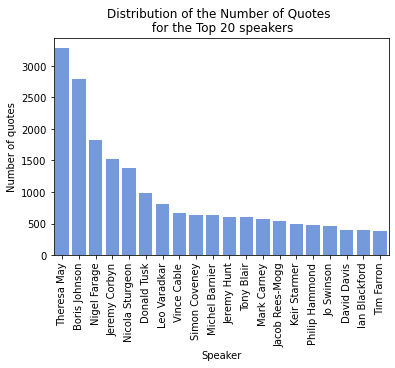

In [6]:
ax = sns.barplot(data = df_speaker, x = 'Speaker', y=('speaker_qid', 'count'),  color='cornflowerblue',alpha=1)
ax.set_xticklabels(df_speaker['Speaker'], rotation=90)
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 speakers')
plt.ylabel('Number of quotes')
plt.show()

### Where these Quotations come from ?
Let's first have a look at where these quotations come from by analyzing the nationalities of different speakers on the Brexit.

In [7]:
Nations = brexit_enriched['nationality'].explode().value_counts()
Top20_Nations = Nations[:20]
Top20_Nations.head()

United Kingdom              53891
United States of America    11653
Ireland                      6898
Australia                    2648
Canada                       2342
Name: nationality, dtype: int64

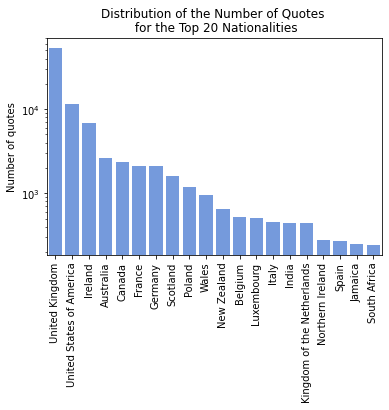

In [8]:
ax = sns.barplot(Top20_Nations.index, Top20_Nations.values,color='cornflowerblue',alpha=1)
ax.set_xticklabels(Top20_Nations.index, rotation=90)
ax.set_yscale("log")
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 Nationalities')
plt.ylabel('Number of quotes')
plt.show()

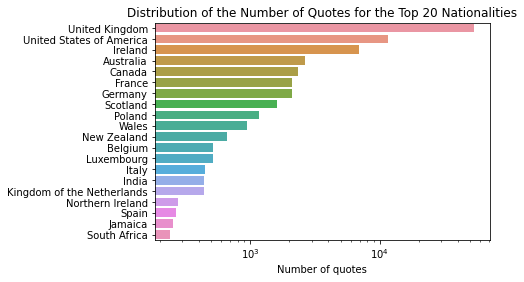

In [9]:
ax = sns.barplot(Top20_Nations.values,Top20_Nations.index,alpha=1, orient = "h")
ax.set_xscale("log")
ax.set_title('Distribution of the Number of Quotes for the Top 20 Nationalities')
plt.xlabel('Number of quotes')
plt.show()

After visualizing the top 20 nations talking about the Brexit, it's obvious that most of speakers talking about the Brexit came from dominant countries in the world, for example, the United Kindom, the United States of America, Australia and so on. As this event, Brexit, was mostly about the European situation, we can observe that most countries in the top 20 nations talking about the Brexit were from the Europe, which shows that people care about the Brexit are mostly from the Europe.

### Gender of Speakers about the Brexit

In [10]:
Gender = brexit_enriched['gender'].explode().value_counts()
Gender.head()

male                75881
female              19200
eunuch                 31
cisgender female       26
non-binary             14
Name: gender, dtype: int64

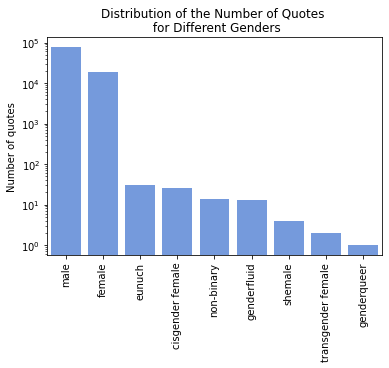

In [11]:
ax = sns.barplot(Gender.index, Gender.values,color='cornflowerblue',alpha=1)
ax.set_xticklabels(Gender.index, rotation=90)
ax.set_yscale("log")
ax.set_title('Distribution of the Number of Quotes \n for Different Genders')
plt.ylabel('Number of quotes')
plt.show()

### Speakers' occupation behind Brexit-related quotations

In [12]:
Occupations = brexit_enriched['occupation'].explode().value_counts()
Top20_Occupations = Occupations[:20]
Top20_Occupations.head()

politician    54383
journalist     9374
writer         8021
lawyer         6583
economist      4894
Name: occupation, dtype: int64

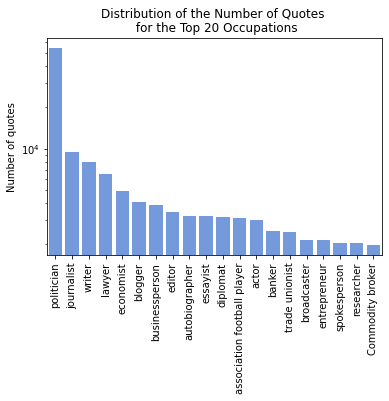

In [13]:
ax = sns.barplot(Top20_Occupations.index, Top20_Occupations.values,color='cornflowerblue',alpha=1)
ax.set_xticklabels(Top20_Occupations.index, rotation=90)
ax.set_yscale("log")
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 Occupations')
plt.ylabel('Number of quotes')
plt.show()

### Quotations numbers change from 2016 to 2020
We want to see how the number of quotations change from 2016 to 2020. In this way, we can obtain the popularity change of Brexit in this period.

In [14]:
df["year"] = df["date"].apply(lambda x :x.split("-")[0])
df["month"] = df["date"].apply(lambda x :x.split("-")[1])
change_by_year = df.groupby(["year","month"])["date"].count().reset_index()
change_by_year.rename(columns={"date": "count"},inplace = True)
change_by_year["year_month"] = change_by_year.year + "-" + change_by_year.month
change_by_year.head()

,year,month,count,year_month
0,2016,01,1,2016-01
1,2016,02,154,2016-02
2,2016,03,2,2016-03
3,2016,04,166,2016-04
4,2016,05,498,2016-05


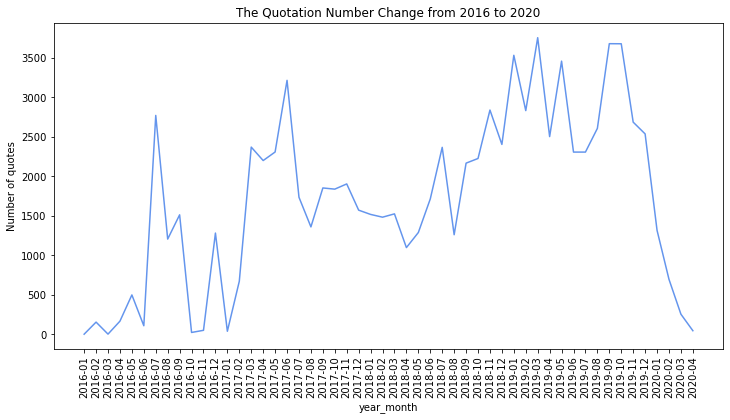

In [15]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data = change_by_year, x = 'year_month', y= 'count',  color='cornflowerblue',alpha=1)
ax.set_xticklabels(change_by_year['year_month'], rotation=90)
ax.set_title('The Quotation Number Change from 2016 to 2020')
plt.ylabel('Number of quotes')
plt.show()

### Topic Detection

In [16]:
qutation_data = df[["date","quotation"]]
qutation_data.head()

,date,quotation
0,2016-09-07,Corbyn shows his true colours. Rather than att...
1,2016-08-11,People are nervous and universities are being ...
2,2016-07-05,best placed to help forge a great post Brexit ...
3,2016-12-14,In the run-up to the Brexit vote earlier this ...
4,2016-07-25,"On the issue of Brexit, I speak for the people..."


#### Build Tokenizer
Here we build a tokenizer. This will, for every quotation:
1. lowercase the text and clean it (separate function)
2. break the descriptions into sentences and then break the sentences into tokens
3. remove punctuation, stop words
The first step is done by the clean_text function defined below.

Tokenization is a process to seprate the sentences into single words and punctuations.The second step is done by sent_tokenize from nltk.tokenize and word_tokenize from nltk.tokenize.

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. We have adopted stopwords file from https://github.com/ahmedbesbes/How-to-mine-newsfeed-data-and-extract-interactive-insights-in-Python/blob/master/data/stopwords.txt. We also add the stopword from nltk.corpus. Here you can also add your stopword into the additional_stop_words list.

In [17]:
# They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [18]:
stop_words = []

# load the stopwords file 
f = open('stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))

# interface for adding words to the stop_words list
additional_stop_words = ['t', 'will']
stop_words =  stop_words + additional_stop_words + stopwords.words('english')
print("The total stopword is {}".format(len(stop_words)))

The total stopword is 847


In [19]:
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [20]:
qutation_data['tokens'] = qutation_data['quotation'].progress_map(lambda d: tokenizer(d))

progress-bar:   0%|          | 0/88881 [00:00<?, ?it/s]

In [21]:
qutation_data.head()

,date,quotation,tokens
0,2016-09-07,Corbyn shows his true colours. Rather than att...,"[corbyn, true, colours, attacking, divided, br..."
1,2016-08-11,People are nervous and universities are being ...,"[people, nervous, universities, defensive, eu,..."
2,2016-07-05,best placed to help forge a great post Brexit ...,"[best, help, forge, great, post, brexit, futur..."
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,"[brexit, vote, earlier, year, fed, policymaker..."
4,2016-07-25,"On the issue of Brexit, I speak for the people...","[issue, brexit, speak, people, north, people, ..."


#### Part of Speech Tagging and Lemmatization
Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.

Generally, lemmatization is followed by Part of Speech Tagging (POS-Tag), which is the labeling of the words in a text according to their word types (noun, adjective, adverb, verb, etc.) POS tagging is a supervised learning solution that uses features like the previous word, next word, is first letter capitalized etc. NLTK has a function to get pos tags and it works after tokenization process. Detailed tags can be found here(https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

NLTK provides WordNetLemmatizer class which is a thin wrapper around the wordnet corpus.

In [22]:
qutation_data['POS_tokens'] = qutation_data['tokens'].progress_map(lambda tokens: pos_tag(tokens))

progress-bar:   0%|          | 0/88881 [00:00<?, ?it/s]

In [23]:
qutation_data.head()


,date,quotation,tokens,POS_tokens
0,2016-09-07,Corbyn shows his true colours. Rather than att...,"[corbyn, true, colours, attacking, divided, br...","[(corbyn, NN), (true, JJ), (colours, NNS), (at..."
1,2016-08-11,People are nervous and universities are being ...,"[people, nervous, universities, defensive, eu,...","[(people, NNS), (nervous, JJ), (universities, ..."
2,2016-07-05,best placed to help forge a great post Brexit ...,"[best, help, forge, great, post, brexit, futur...","[(best, JJS), (help, NN), (forge, VB), (great,..."
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,"[brexit, vote, earlier, year, fed, policymaker...","[(brexit, NN), (vote, NN), (earlier, RBR), (ye..."
4,2016-07-25,"On the issue of Brexit, I speak for the people...","[issue, brexit, speak, people, north, people, ...","[(issue, NN), (brexit, NN), (speak, JJ), (peop..."


In [24]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()
qutation_data['tokens_after_lemmatized'] = qutation_data['POS_tokens'].progress_map(
    lambda list_tokens_POS:
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in list_tokens_POS
        ] 
        
)

progress-bar:   0%|          | 0/88881 [00:00<?, ?it/s]

#### Phrase detection
We need to automatically detect common phrases like multi-word expressions, word n-gram collocations from a stream of tokens. Here we use bigram and trigram

In [25]:
tokens = qutation_data['tokens_after_lemmatized'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Create the dictionary
In Gensim, the dictionary object is used to create a bag of words (BoW) corpus which further used as the input to topic modelling and other models as well.

Corpus − It refers to a collection of documents as a bag of words (BoW).

Here we define three functions:
1. LDA_model, this function returns the LDA model
2. compute_coherence, this function is used to compute coherence score to evaluate the LDA model
3. display_topics, function to display topics and corresponding keywords:
3. explore model. this is a tuning function, used to explore different topics of LDA models.

In [26]:
dict_LDA = corpora.Dictionary(tokens)
dict_LDA.filter_extremes(no_below=1)
corpus = [dict_LDA.doc2bow(tok) for tok in tokens]

def LDA_model(num_topics,corpus, id2word, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True
                                            )
def compute_coherence(model,tokens, id2word):
    coherence = CoherenceModel(model=model, 
                           texts=tokens,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=num_words)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, num_words+1)]
    return df

def explore_models(corpus, id2word, tokens, rg=range(5, 25)):
    models = []
    coherences = []
    
    for num_topics in rg:
        lda_model = LDA_model(num_topics,corpus, id2word, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model, tokens, id2word)
        coherences.append(coherence)
      
    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models


In [ ]:
coherences, models = explore_models(corpus, dict_LDA, tokens, rg=range(3, 9))

In [27]:
best_model = LDA_model(num_topics=5, corpus=corpus, id2word=dict_LDA, passes=5)

display_topics(model=best_model, num_words=5)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5
topic_0,deal,people,vote,party,deliver
topic_1,uk,business,deal,eu,government
topic_2,general_election,risk,delay,threat,crisis
topic_3,year,uncertainty,market,economy,deal
topic_4,scotland,eu,uk,people,deal


#### Visualization of LDA model

In [28]:
vis = pyLDAvis.gensim_models.prepare(topic_model=best_model, corpus=corpus, dictionary=dict_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

#### Sentiment Analysis
NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner). Since VADER is pretrained, you can get results more quickly than with many other analyzers. 

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

1. positive sentiment : (compound score >= 0.05) 
2. neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
3. negative sentiment : (compound score <= -0.05)

In [29]:
# applying sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

df['sentiment_score'] = df["quotation"].apply(lambda x: sentiment_analyzer.polarity_scores(x)["compound"])
df.head()

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age,year,month,sentiment_score
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0,2016,09,-0.6486
1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0,2016,08,-0.2023
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0,2016,07,0.9001
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0,2016,12,-0.7430
4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0,2016,07,0.3818


In [30]:
def get_sentiment(sentiment_score):
    if (sentiment_score < -0.05):
        return "negative"
    elif (sentiment_score < 0.05):
        return "neutral"
    else:
        return "positive"
    
df['sentiment'] = df.sentiment_score.apply(lambda x: get_sentiment(x))
df.head()

,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age,year,month,sentiment_score,sentiment
0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0,2016,09,-0.6486,negative
1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0,2016,08,-0.2023,negative
2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0,2016,07,0.9001,positive
3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0,2016,12,-0.7430,negative
4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0,2016,07,0.3818,positive


This is the distribution of all the quotations. From the graph, we can see the positive quotations are more than negative ones.

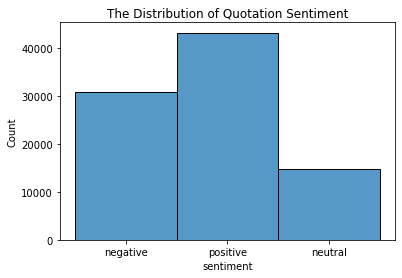

In [31]:
ax = sns.histplot(df['sentiment'])
ax.set_title('The Distribution of Quotation Sentiment')
plt.show()

This is the distribution of all the quotations from UK people. From the graph, we can see the positive quotations are still more than negative ones. That is maybe the reason that why Brexit can happen.

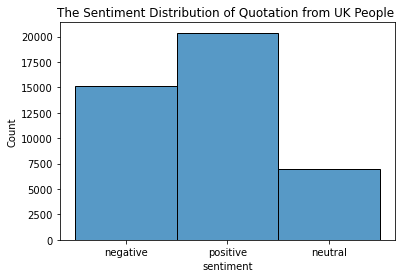

In [32]:
uk_sentiment = df[df.nationality == "['United Kingdom']"]
ax = sns.histplot(uk_sentiment['sentiment'])
ax.set_title('The Sentiment Distribution of Quotation from UK People ')
plt.show()

In [50]:
sentiment_month_change = uk_sentiment.groupby(["year","month","sentiment"])["quotation"].count().reset_index()
sentiment_month_change["year_month"] = sentiment_month_change.year + "-" +sentiment_month_change.month
sentiment_month_change.rename(columns={"quotation": "count"},inplace = True)
sentiment_month_change.head()

,year,month,sentiment,count,year_month
0,2016,01,negative,1,2016-01
1,2016,02,negative,25,2016-02
2,2016,02,neutral,8,2016-02
3,2016,02,positive,16,2016-02
4,2016,04,negative,27,2016-04


In [51]:
sum_by_month = sentiment_month_change.groupby(["year","month"])["count"].sum().reset_index()
sum_by_month.rename(columns={"count": "sum_by_month"},inplace = True)
sentiment_month_change = sentiment_month_change.merge(sum_by_month, on = ["year","month"])
sentiment_month_change["percentage"] = sentiment_month_change["count"]/sentiment_month_change["sum_by_month"]
sentiment_month_change.head()

,year,month,sentiment,count,year_month,sum_by_month,percentage
0,2016,01,negative,1,2016-01,1,1.000000
1,2016,02,negative,25,2016-02,49,0.510204
2,2016,02,neutral,8,2016-02,49,0.163265
3,2016,02,positive,16,2016-02,49,0.326531
4,2016,04,negative,27,2016-04,62,0.435484


In [59]:
sentiment_month_change.tail()

,year,month,sentiment,count,year_month,sum_by_month,percentage
146,2020,03,neutral,18,2020-03,100,0.180000
147,2020,03,positive,39,2020-03,100,0.390000
148,2020,04,negative,6,2020-04,18,0.333333
149,2020,04,neutral,5,2020-04,18,0.277778
150,2020,04,positive,7,2020-04,18,0.388889


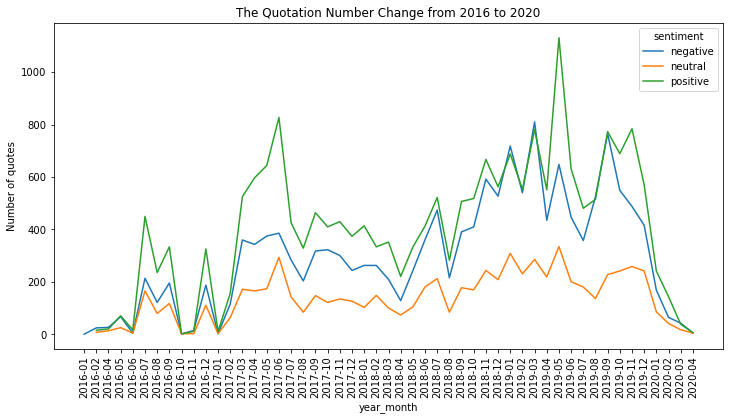

In [54]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data = sentiment_month_change, x = 'year_month', y= 'count',hue = 'sentiment')
ax.set_xticklabels(sentiment_month_change['year_month'].unique(), rotation=90)
ax.set_title('The Quotation Number Change from 2016 to 2020')
plt.ylabel('Number of quotes')
plt.show()

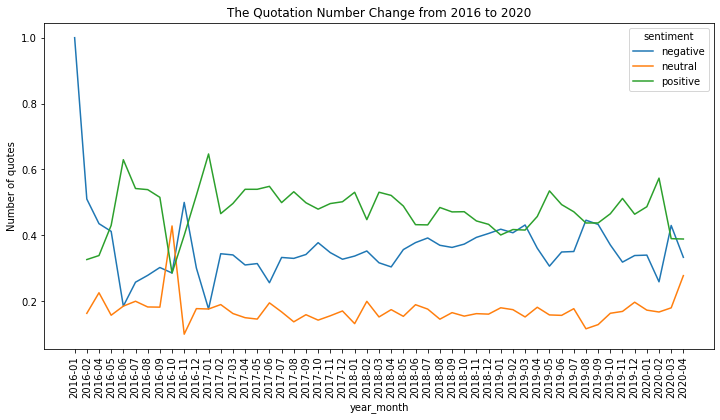

In [55]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data = sentiment_month_change, x = 'year_month', y= 'percentage',hue = 'sentiment')
ax.set_xticklabels(sentiment_month_change['year_month'].unique(), rotation=90)
ax.set_title('The Quotation Number Change from 2016 to 2020')
plt.ylabel('Number of quotes')
plt.show()

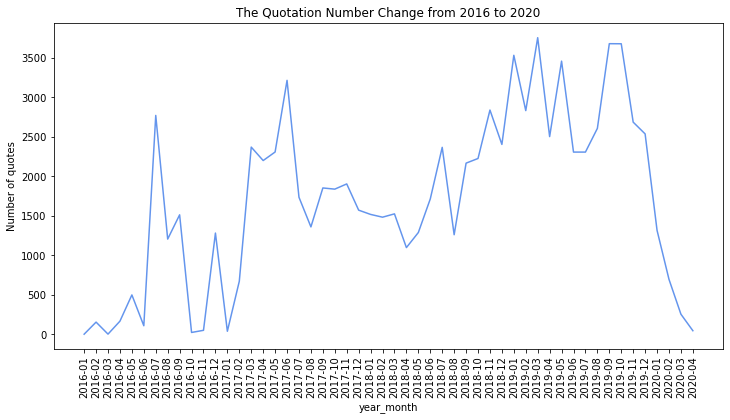

In [58]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data = change_by_year, x = 'year_month', y= 'count',  color='cornflowerblue',alpha=1)
ax.set_xticklabels(change_by_year['year_month'], rotation=90)
ax.set_title('The Quotation Number Change from 2016 to 2020')
plt.ylabel('Number of quotes')
plt.show()

From checking online, the UK holds a referendum on whether to leave the European Union on 23 June. 52% of voters vote to leave. This is the start point of Brexit. This is also reflected from the line chart above that there is steep increase number of quotations about Brexit with about 10 times more. On November, in the Miller case, the High Court ruled against the Secretary of State for Exiting the European Union on the question of whether notice could be given under Article 50 of the Treaty on European Union using the Royal prerogative. On December, the House of Commons votes 461 to 89 in favour of Theresa May's plan to trigger Article 50 by the end of March 2017. That is the reason that why there is an sudden increase about Brexit quotations.

On March 2017, a letter from Theresa May is handed to President of the European Council Donald Tusk to invoke Article 50, starting a two-year process with the UK due to leave the EU on 29 March 2019. Brexit negotiations commence on 19 June. This also resulted in heated discussion on newspapers. The number of quotations reached the largest during 2017 period.